<a href="https://colab.research.google.com/github/dine1717/END2/blob/Session14/BERT_Tutorial_How_To_Build_a_Question_Answering_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# install huggingface libraries
! pip install pytorch-pretrained-bert==0.6.2 pytorch-nlp==0.5.0 pytorch_transformers==1.2.0

In [3]:
! git clone https://github.com/nlpyang/pytorch-transformers && cd pytorch-transformers && git checkout e00b4ff1de0591d5093407b16e665e5c86028f04

Cloning into 'pytorch-transformers'...
remote: Enumerating objects: 6469, done.
remote: Total 6469 (delta 0), reused 0 (delta 0), pack-reused 6469
Receiving objects: 100% (6469/6469), 3.60 MiB | 8.11 MiB/s, done.
Resolving deltas: 100% (4641/4641), done.
Note: checking out 'e00b4ff1de0591d5093407b16e665e5c86028f04'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at e00b4ff fix #1017


In [4]:
! git clone https://github.com/chrischute/squad && cd squad && git checkout 85623adeb9e6639f145081fea9cae2d8f3a26379

Cloning into 'squad'...
remote: Enumerating objects: 41, done.
remote: Total 41 (delta 0), reused 0 (delta 0), pack-reused 41
Unpacking objects: 100% (41/41), done.
Note: checking out '85623adeb9e6639f145081fea9cae2d8f3a26379'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 85623ad Update Miniconda URL in README.md


In [5]:
import sys
if 'pytorch-transformers/examples' not in sys.path: print('adding squad utils to path') ; sys.path.insert(0, 'pytorch-transformers/examples')

adding squad utils to path


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm.auto import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [8]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
input_file = 'squad/data/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [11]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [12]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [13]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
100910,572e844703f989190075670b,How many yards wide is a Canadian football field?,"[The, Canadian, football, field, is, 150, yard...",65,11,11,False
100911,572e844703f989190075670c,How long in meters is the crossbar of a Canadi...,"[The, Canadian, football, field, is, 150, yard...",5.6,54,54,False
100912,572e844703f989190075670d,What part of a Canadian football field was som...,"[The, Canadian, football, field, is, 150, yard...",goal line,220,221,False
100913,572e844703f989190075670e,What distance from the sidelines are hash mark...,"[The, Canadian, football, field, is, 150, yard...",24 yards (21.9 m),255,258,False
100914,5a0e220fd7c8500018864541,Whose football fields are hundred 50 yards wid...,"[The, Canadian, football, field, is, 150, yard...",,-1,-1,True
100915,5a0e220fd7c8500018864542,What are marked with yellow sidelines?,"[The, Canadian, football, field, is, 150, yard...",,-1,-1,True
100916,5a0e220fd7c8500018864543,What fields have expanded in zones?,"[The, Canadian, football, field, is, 150, yard...",,-1,-1,True
100917,5a0e220fd7c8500018864544,Where was it uncommon to put her over the track?,"[The, Canadian, football, field, is, 150, yard...",,-1,-1,True
100918,5a0f51d4decec90018475561,"In most running tracks today, what are marked?","[The, Canadian, football, field, is, 150, yard...",,-1,-1,True
100919,5a0f51d4decec90018475562,In higher calibre stadiums what is preferred?,"[The, Canadian, football, field, is, 150, yard...",,-1,-1,True


In [14]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [15]:
print_squad_sample(train_data)

CONTEXT: 
Because the Quran is spoken in classical Arabic, many of the later converts to
Islam (mostly non-Arabs) did not always understand the Quranic Arabic, they did not catch
allusions that were clear to early Muslims fluent in Arabic and they were concerned
with reconciling apparent conflict of themes in the Quran. Commentators erudite in Arabic explained
the allusions, and perhaps most importantly, explained which Quranic verses had been revealed early
in Muhammad's prophetic career, as being appropriate to the very earliest Muslim community, and
which had been revealed later, canceling out or "abrogating" (nāsikh) the earlier text (mansūkh).
Other scholars, however, maintain that no abrogation has taken place in the Quran. The
Ahmadiyya Muslim Community has published a ten-volume Urdu commentary on the Quran, with the
name Tafseer e Kabir.
QUESTION:                                                                                            ANSWER:
In which language is the Quran r

In [16]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
101486,572e87bedfa6aa1500f8d0cc,What is the name of the antimatter counterpart...,"[He, also, developed, Feynman, diagrams,, a, b...",positrons,28,28,False,96,60
49745,57255c8a69ff041400e58c39,Where was a rally calling for Queen Victoria's...,"[In, 1870,, republican, sentiment, in, Britain...",Trafalgar Square,25,26,False,153,61
45129,570ff265b654c5140001f6de,"Along with aggravating factors, what other fac...","[In, 1976,, contemporaneously, with, Woodson, ...",mitigating,75,75,False,105,88
69293,5ace1a7c32bba1001ae49acb,Who built on Islamic mathmatical systems?,"[Ibn, Sina, created, an, extensive, corpus, of...",,-1,-1,True,117,41
61688,57288e8eff5b5019007da2e8,What is the name of the newspaper that was ban...,"[Restrictions, on, media, censorship, were, si...",The Irrawaddy,63,64,False,180,63


In [17]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 945288.89B/s]


In [19]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [20]:
cached_features_file = 'cache_train'

In [21]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [22]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [23]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [24]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [25]:
import glob
checkpoints = sorted(glob.glob('checkpoint*-[0-9]*'))

In [26]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [27]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = 'checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:54<00:00, 8008988.86B/s] 


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [28]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0249, -0.0096, -0.0563,  ...,  0.0133, -0.0158,  0.0127],
        [-0.0049,  0.0425, -0.0153,  ..., -0.0341,  0.0218,  0.0003]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [29]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [30]:
num_train_epochs = 1
fraction_per_epoch = 0.2

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // (num_train_epochs * fraction_per_epoch)))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

train_dataset_fraction = torch.utils.data.Subset(dataset, list(range(0, round(len(dataset) * fraction_per_epoch))))
train_dataloader_fraction = DataLoader(train_dataset_fraction, batch_size=batch_size, drop_last=True)

for _ in train_iterator:
    epoch_iterator = tqdm(iter(train_dataloader_fraction), desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = 'checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 45079


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1803 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 1.7028252339065075
Saving model checkpoint to checkpoint-1000


In [31]:
output_dir = 'checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [32]:
train_loss_set_ckpt = torch.load('checkpoint-1000/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

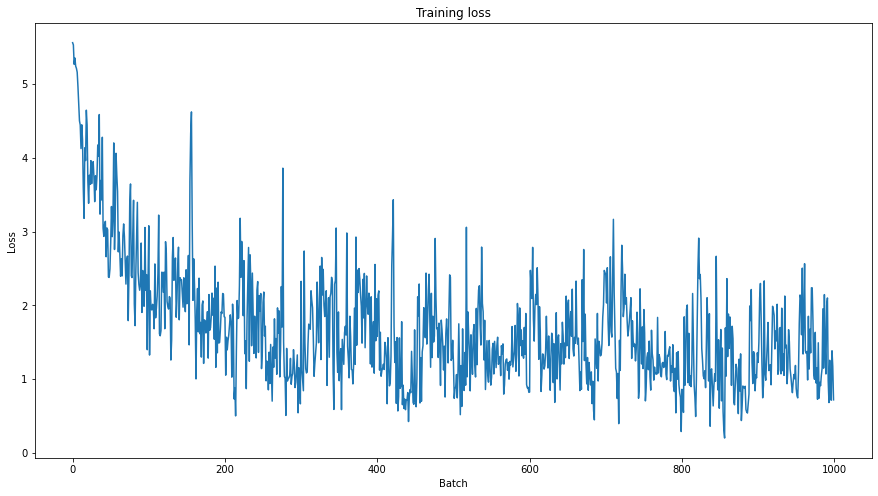

In [33]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [34]:
input_file = 'squad/data/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = 'cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [35]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [36]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=False)

**Evaluate test dataset**

In [37]:
print("***** Running evaluation *****")
print("  Num examples = %d" % len(dataset))
print("  Batch size = %d" % batch_size)
all_results = []
predict_file = 'squad/data/dev-v2.0.json'
for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
        example_indices = batch[3]
        outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
        eval_feature = features[example_index.item()]
        unique_id = int(eval_feature.unique_id)

        result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
        all_results.append(result)

***** Running evaluation *****
  Num examples = 7205
  Batch size = 16


Evaluating:   0%|          | 0/451 [00:00<?, ?it/s]

In [38]:
len(all_results), len(features)

(7205, 7205)

In [39]:
# Compute predictions
output_prediction_file = "predictions.json"
output_nbest_file = "nbest_predictions.json"
output_null_log_odds_file = "null_odds.json"

In [40]:
write_predictions(val_examples, features, all_results, 10,
                30, True, output_prediction_file,
                output_nbest_file, output_null_log_odds_file, False,
                True, 0.0)

OrderedDict([('68cf05f67fd29c6f129fe2fb9', 'France'),
             ('f5fead9187d56af2bdbfcb921', ''),
             ('f9183ead5bb93aaa12ea37245', ''),
             ('1fc4da46445c2c1c2dc0ddeda', 'Rollo'),
             ('1be9fa378cbee6d9fa8b6ac78', ''),
             ('c42edddd0f45b968cc4c512e5', 'The Normans'),
             ('d583847c96cbbbfaaa99dfcad', ''),
             ('e06fbbdb50af7ab3faefde618', 'Rollo'),
             ('cbb48eaacbbbfcccefb7aab7f', ''),
             ('6d2fff36bcac0ea0e689a5a31', 'William the Conqueror'),
             ('faf67818ee17102d8c16cc9e5', 'William the Conqueror'),
             ('e688568f9e7fd2700aea3d75d', 'Catholic orthodoxy'),
             ('e7a1efbabdb13fbc36df8e179', 'political, cultural and military'),
             ('b5e6efbccbf6feb8dddbbce8d', 'The Normans'),
             ('b3c16b20fa0daff05d74bedfc', ''),
             ('71eb21da6ccfcfebdd3fc384e', ''),
             ('e1b5fab52e5afa35bf1cfce1c', ''),
             ('f8a7c2ed64befec7ec9c5ea0a', ''),
      

In [41]:
# Evaluate with the official SQuAD script
evaluate_options = EVAL_OPTS(data_file=predict_file,
                            pred_file=output_prediction_file,
                            na_prob_file=output_null_log_odds_file,
                            out_image_dir=None)
results = evaluate_on_squad(evaluate_options)

{
  "exact": 61.829549193813754,
  "f1": 63.61269776055754,
  "total": 6078,
  "HasAns_exact": 41.512027491408936,
  "HasAns_f1": 45.236418209164604,
  "HasAns_total": 2910,
  "NoAns_exact": 80.49242424242425,
  "NoAns_f1": 80.49242424242425,
  "NoAns_total": 3168,
  "best_exact": 61.9282658769332,
  "best_exact_thresh": -0.09904193878173828,
  "best_f1": 63.662056102117205,
  "best_f1_thresh": -0.006443977355957031
}


In [42]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 61.829549193813754}, {'f1': 63.61269776055754}, {'total': 6078}, {'HasAns_exact': 41.512027491408936}, {'HasAns_f1': 45.236418209164604}, {'HasAns_total': 2910}, {'NoAns_exact': 80.49242424242425}, {'NoAns_f1': 80.49242424242425}, {'NoAns_total': 3168}, {'best_exact': 61.9282658769332}, {'best_exact_thresh': -0.09904193878173828}, {'best_f1': 63.662056102117205}, {'best_f1_thresh': -0.006443977355957031}]


**Evaluate on any text**

In [45]:
with open('predictions.json') as f:
    best_predictions = json.load(f)

In [46]:
import random

for example in random.sample(val_examples, 40):
    qas_id = example.qas_id
    question_text = example.question_text
    answer_text = best_predictions[qas_id]

    print(f'question       >> {question_text}')
    print(f'model\'s answer >> {answer_text}')

    print()

question       >> Why did Radcliffe College students stop residing at Sever Hall?
model's answer >> 

question       >> Who is not responsible for ensuring Parliament runs smoothly?
model's answer >> 

question       >> What techniques did Chinese medicine never include?
model's answer >> 

question       >> What does the past time and space hierarchy theorems form the basis of?
model's answer >> 

question       >> What is usually taken as the best case complexity, unless specified otherwise?
model's answer >> 

question       >> What persons were not allowed to settle in New France?
model's answer >> 

question       >> How much did Saudi Arabia spend on spreading Wahhabism?
model's answer >> over 100 billion dollars

question       >> Which country's arms purchase from the US became 5 times more than Israel?
model's answer >> 

question       >> Who didn't Dinwiddie order to address French in Virginia territory?
model's answer >> 

question       >> What was the Yuan dynasty called 